# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-03-02/data_eval_new/"
file_name = "int_norm_20160302_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

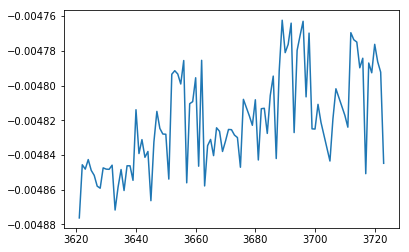

In [7]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

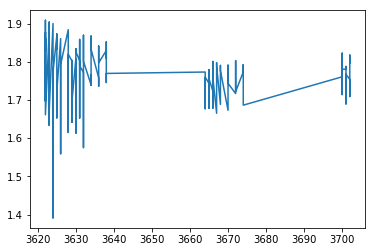

In [8]:
# Check Signals
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [9]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 100ppb', 'SPEX1 100ppb', 'NIST 200ppb', 'SPEX1 200ppb',
       'NIST 350ppb', 'SPEX1 350ppb'], dtype=object)

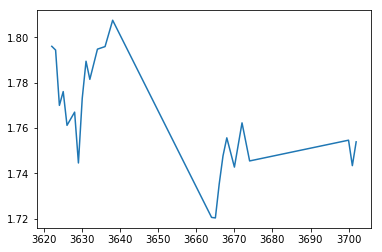

In [10]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

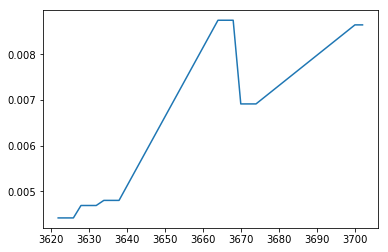

In [11]:
# Check background 
column = "120"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [12]:
background_mean = df_mean(background)

In [13]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [14]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [108]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [109]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [110]:
column = "124/120"
sample = "NIST 200ppb"

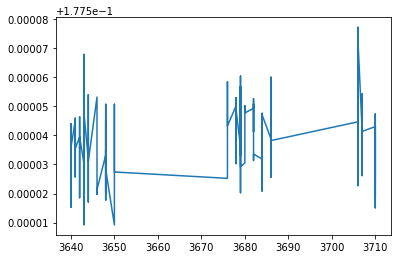

In [111]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [112]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [113]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2016-03-02 15:50:00,NIST 100ppb,2,1,3622,0.029825,0.020200,0.010357,0.445980,0.235312,NaN,0.263453,0.142081,0.177528
2016-03-02 15:50:00,NIST 100ppb,2,2,3622,0.029826,0.020191,0.010362,0.445989,0.235312,0.742935,0.263464,0.142075,0.177530
2016-03-02 15:50:00,NIST 100ppb,2,3,3622,0.029816,0.020182,0.010359,0.445952,0.235294,NaN,0.263452,0.142085,0.177534
2016-03-02 15:50:00,NIST 100ppb,2,4,3622,0.029813,0.020195,0.010364,0.445981,0.235290,NaN,0.263480,0.142081,0.177558
2016-03-02 15:50:00,NIST 100ppb,2,5,3622,0.029821,0.020187,0.010363,0.445990,0.235297,0.742935,0.263466,0.142081,0.177549
2016-03-02 15:50:00,NIST 100ppb,2,6,3622,0.029819,0.020191,0.010359,0.445979,0.235304,0.742935,0.263456,0.142084,0.177539
2016-03-02 15:50:00,NIST 100ppb,2,7,3622,0.029819,0.020191,0.010360,0.445989,0.235311,0.742935,0.263458,0.142075,0.177546
2016-03-02 15:50:00,NIST 100ppb,2,8,3622,0.029822,0.020196,0.010362,0.446003,0.235316,0.742935,0.263469,0.142072,0.177533
2016-03-02 15:50:00,NIST 100ppb,2,9,3622,0.029819,0.020191,0.010362,0.446001,0.235306,0.742935,0.263459,0.142060,0.177523


In [114]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
3623        2016-03-02 16:04:00    0.177554
3624        2016-03-02 16:19:00    0.177492
            2016-03-02 16:19:00    0.177591
3636        2016-03-02 19:07:00    0.177559
3643        2016-03-02 20:45:00    0.177568
3648        2016-03-02 21:55:00    0.177551
3655        2016-03-02 23:33:00    0.177517
3661        2016-03-03 00:57:00    0.177514
            2016-03-03 00:57:00    0.177498
            2016-03-03 00:57:00    0.177492
3664        2016-03-03 01:39:00    0.177661
3684        2016-03-03 06:19:00    0.177523
            2016-03-03 06:19:00    0.177521
3686        2016-03-03 06:48:00    0.177560
            2016-03-03 06:48:00    0.177527
            2016-03-03 06:48:00    0.177526
            2016-03-03 06:48:00    0.177526
3695        2016-03-03 08:53:00    0.177562
            2016-03-03 08:53:00    0.177554
3706        2016-03-03 11:27:00    0.177577
Name: 124/120, dtype: float64

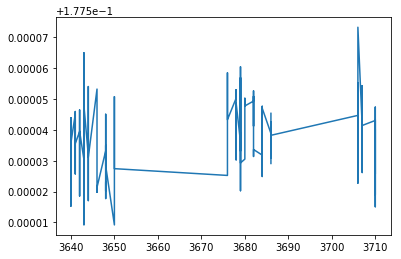

In [115]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [116]:
df[df["Sample"] == sample][column].std()

9.184722641959847e-06

In [117]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [118]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

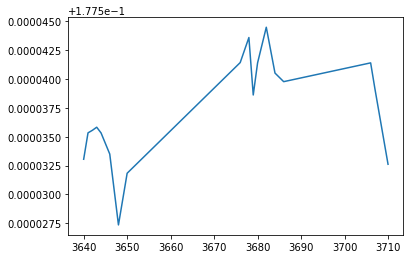

In [119]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [120]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2016-03-02 15:50:00,3622,NIST 100ppb,0.029821,0.020191,0.010361,0.445987,0.235303,0.742935,0.263462,0.142077,0.177535,0.000148,0.000050
2016-03-02 16:04:00,3623,NIST 100ppb,0.029821,0.020190,0.010360,0.445997,0.235310,0.742935,0.263464,0.142077,0.177534,0.000155,0.000054
2016-03-02 16:19:00,3624,NIST 100ppb,0.029821,0.020190,0.010361,0.446004,0.235312,0.742935,0.263462,0.142076,0.177531,0.000154,0.000059
2016-03-02 16:33:00,3625,NIST 100ppb,0.029821,0.020189,0.010361,0.445994,0.235310,0.742935,0.263461,0.142074,0.177526,0.000166,0.000060
2016-03-02 16:47:00,3626,NIST 100ppb,0.029822,0.020190,0.010363,0.446007,0.235317,0.742935,0.263461,0.142075,0.177525,0.000152,0.000053
2016-03-02 17:14:00,3628,NIST 100ppb,0.029823,0.020190,0.010361,0.446004,0.235314,0.742935,0.263461,0.142079,0.177530,0.000150,0.000048
2016-03-02 17:28:00,3629,NIST 100ppb,0.029823,0.020190,0.010362,0.446001,0.235313,0.742935,0.263462,0.142077,0.177528,0.000146,0.000061
2016-03-02 17:43:00,3630,NIST 100ppb,0.029822,0.020190,0.010362,0.446003,0.235314,0.742935,0.263464,0.142078,0.177530,0.000141,0.000057
2016-03-02 17:57:00,3631,NIST 100ppb,0.029826,0.020193,0.010361,0.446000,0.235313,0.742935,0.263458,0.142076,0.177529,0.000128,0.000063


In [121]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [122]:
drop_sum = [pd.Timestamp("2016-03-02 20:45:00"), 
            pd.Timestamp("2016-03-02 21:00:00"), 
            pd.Timestamp("2016-03-02 21:26:00"), 
            pd.Timestamp("2016-03-02 21:55:00"),
            pd.Timestamp("2016-03-02 22:24:00"),
            pd.Timestamp("2016-03-03 00:29:00"),
            pd.Timestamp("2016-03-03 00:57:00"),
            pd.Timestamp("2016-03-03 04:55:00"), 
            pd.Timestamp("2016-03-03 05:09:00"), 
            pd.Timestamp("2016-03-03 06:19:00"), 
            pd.Timestamp("2016-03-03 12:25:00")]

In [123]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [124]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [125]:
data_mean_int_sum

112/120                   114/120                   115/120  \
                  mean       SD2 count      mean       SD2 count      mean   
Sample                                                                       
NIST 100ppb   0.029824  0.000005    24  0.020192  0.000005    24  0.010362   
NIST 200ppb   0.029822  0.000005     9  0.020190  0.000005     9  0.010363   
NIST 350ppb   0.029828  0.000001    24  0.020194  0.000002    24  0.010365   
SPEX1 100ppb  0.029823  0.000002     4  0.020190  0.000002     4  0.010370   
SPEX1 200ppb  0.029824  0.000002     4  0.020191  0.000003     4  0.010371   
SPEX1 350ppb  0.029825  0.000005     4  0.020193  0.000002     4  0.010371   

                                   116/120  ...  122/120   124/120            \
                       SD2 count      mean  ...    count      mean       SD2   
Sample                                      ...                                
NIST 100ppb   2.755840e-06    24  0.446004  ...       24  0.177536  0.000013   
NIST 200ppb   1.904108e-06     9  0.445993  ...        9  0.177539  0.000007   
NIST 350ppb   7.152738e-07    24  0.446023  ...       24  0.177536  0.000006   
SPEX1 100ppb  4.327872e-06     4  0.446000  ...        4  0.177537  0.000014   
SPEX1 200ppb  1.060087e-06     4  0.446004  ...        4  0.177537  0.000004   
SPEX1 350ppb  9.687561e-07     4  0.446006  ...        4  0.177534  0.000009   

                       Cd/Sn                     Te/Sn                  
             count      mean       SD2 count      mean       SD2 count  
Sample                                                                  
NIST 100ppb     24  0.000120  0.000054    24  0.000059  0.000011    24  
NIST 200ppb      9  0.000064  0.000045     9  0.000055  0.000016     9  
NIST 350ppb     24  0.000027  0.000007    24  0.000055  0.000010    24  
SPEX1 100ppb     4  0.000112  0.000034     4  0.000057  0.000015     4  
SPEX1 200ppb     4  0.000050  0.000014     4  0.000056  0.000006     4  
SPEX1 350ppb     4  0.000031  0.000014     4  0.000058  0.000003     4  

[6 rows x 33 columns]

In [126]:
date_list = [pd.Timestamp("2016-03-02 20:45:00"), 
            pd.Timestamp("2016-03-02 21:00:00"), 
            pd.Timestamp("2016-03-02 21:26:00"), 
            pd.Timestamp("2016-03-02 21:55:00"),
            pd.Timestamp("2016-03-02 22:24:00"),
            pd.Timestamp("2016-03-03 00:29:00"),
            pd.Timestamp("2016-03-03 00:57:00"),
            pd.Timestamp("2016-03-03 04:55:00"), 
            pd.Timestamp("2016-03-03 05:09:00"), 
            pd.Timestamp("2016-03-03 06:19:00"), 
            pd.Timestamp("2016-03-03 12:25:00")]

epsilon_int_NIST_100 = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST_100 = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_NIST_200= SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_NIST_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_NIST_350= SSB(data_mean_int.drop(date_list), "NIST 350ppb", 10000)
delta_raw_NIST_350 = SSB(data_mean_raw.drop(date_list), "NIST 350ppb", 1000)

In [127]:
epsilon_int_NIST_100 = epsilon_int_NIST_100.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_NIST_350 = epsilon_int_NIST_350.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [128]:
epsilon_int_NIST_350[epsilon_int_NIST_350["Filenumber"] > 1]

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-03-03 07:15:00,34.008978,-0.352672,0.048676,-0.795295,-0.080251,-0.003028,-1.110223e-12,0.069484,0.134948,0.322102,NIST 350ppb
2016-03-03 12:51:00,17.541492,-0.470358,-0.994319,-0.834203,-0.072714,-0.040374,2.220446e-12,-0.008379,-0.000449,0.019269,NIST 350ppb


In [129]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)
epsilon_int_SPEX = epsilon_int_SPEX.drop(date_list)
delta_raw_SPEX = delta_raw_SPEX.drop(date_list)

NameError: name 'epsilon_int_NIST' is not defined

In [130]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -2) & (df["Filenumber"] <= 2)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [131]:
epsilon_int_NIST_100 = epsilon_process(epsilon_int_NIST_100)
delta_raw_NIST_100 = epsilon_process(delta_raw_NIST_100)
epsilon_int_NIST_200 = epsilon_process(epsilon_int_NIST_200)
delta_raw_NIST_200 = epsilon_process(delta_raw_NIST_200)
epsilon_int_NIST_350 = epsilon_process(epsilon_int_NIST_350)
delta_raw_NIST_350 = epsilon_process(delta_raw_NIST_350)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
epsilon_int_NIST_100

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-03-02 16:04:00,3623,0.151493,-0.404610,-0.987621,0.023897,0.091899,2.220446e-12,0.100898,0.034513,0.068553,NIST 100ppb
2016-03-02 16:19:00,3624,-0.103878,0.311474,0.848980,0.198769,0.093257,-3.330669e-12,-0.040969,0.046387,0.035110,NIST 100ppb
2016-03-02 16:33:00,3625,0.030238,-0.525624,-1.074902,-0.267182,-0.208515,2.220446e-12,-0.026682,-0.129981,-0.081731,NIST 100ppb
2016-03-02 16:47:00,3626,-0.266077,0.423061,1.690827,0.181027,0.237956,-1.110223e-12,0.025238,-0.092067,-0.209077,NIST 100ppb
2016-03-02 17:14:00,3628,0.306148,-0.248470,-1.626374,0.007702,-0.051876,2.220446e-12,-0.040148,0.196735,0.245367,NIST 100ppb
2016-03-02 17:28:00,3629,0.131763,0.176492,1.038365,-0.061005,-0.058889,-1.110223e-12,-0.016516,-0.084956,-0.144008,NIST 100ppb
2016-03-02 17:43:00,3630,-0.703693,-0.765561,0.238900,0.052776,0.063735,2.220446e-12,0.169558,0.110511,0.094934,NIST 100ppb
2016-03-02 17:57:00,3631,0.766814,0.706858,-0.875921,0.005260,0.001678,-1.110223e-12,-0.184107,-0.172538,-0.187643,NIST 100ppb
2016-03-02 18:12:00,3632,-0.795411,-0.229465,0.010033,-0.061640,-0.126943,-1.110223e-12,0.091378,0.113330,0.234124,NIST 100ppb


In [133]:
epsilon_NIST_100_sum = np.round(epsilon_int_NIST_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_100_sum = np.round(delta_raw_NIST_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_NIST_200_sum = np.round(epsilon_int_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_200_sum = np.round(delta_raw_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_NIST_350_sum = np.round(epsilon_int_NIST_350.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_350_sum = np.round(delta_raw_NIST_350.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_100_sum.append([epsilon_NIST_200_sum, epsilon_NIST_350_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_100_sum.append([delta_raw_NIST_200_sum, delta_raw_NIST_350_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [134]:
epsilon_sum_all

112/120              114/120              115/120               \
                mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                        
NIST 100ppb   -0.095  1.533    18  -0.082  1.734    18  -0.103  1.992    18   
SPEX1 100ppb  -0.778  0.196     4  -0.614  0.914     4   7.104  2.862     4   
NIST 200ppb   -0.976    NaN     1  -0.626    NaN     1   0.623    NaN     1   
NIST 350ppb    0.057  0.596    18   0.021  0.588    18   0.067  0.463    18   
SPEX1 350ppb  -1.201  1.516     4  -1.134  1.078     4   6.417  0.985     4   

             116/120  ...  118/120 119/120              122/120               \
                mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample                ...                                                      
NIST 100ppb   -0.005  ...       18   0.008  0.171    18   0.018  0.246    18   
SPEX1 100ppb  -0.095  ...        4  -0.041  0.163     4  -0.080  0.209     4   
NIST 200ppb   -0.188  ...        1  -0.014    NaN     1   0.092    NaN     1   
NIST 350ppb    0.008  ...       18  -0.005  0.139    18  -0.013  0.232    18   
SPEX1 350ppb  -0.329  ...        4  -0.097  0.082     4   0.054  0.222     4   

             124/120               
                mean    SD2 count  
Sample                             
NIST 100ppb    0.012  0.290    18  
SPEX1 100ppb  -0.070  0.271     4  
NIST 200ppb    0.058    NaN     1  
NIST 350ppb   -0.017  0.319    18  
SPEX1 350ppb  -0.145  0.502     4  

[5 rows x 27 columns]

In [135]:
delta_raw_sum_all

112/120              114/120              115/120               \
                mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                        
NIST 100ppb    0.016  0.523    18   0.012  0.459    18   0.005  0.418    18   
SPEX1 100ppb  -0.844  0.211     4  -0.626  0.090     4   0.238  0.313     4   
NIST 200ppb   -0.157  0.872     3  -0.135  0.651     3  -0.050  0.559     3   
NIST 350ppb    0.009  0.305    20   0.003  0.202    20   0.008  0.179    20   
SPEX1 350ppb   0.137  1.892     4   0.081  1.488     4   0.797  1.193     4   

             116/120  ...  118/120 119/120              122/120               \
                mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample                ...                                                      
NIST 100ppb    0.013  ...       18   0.004  0.068    18  -0.005  0.139    18   
SPEX1 100ppb  -0.385  ...        4  -0.095  0.030     4   0.172  0.039     4   
NIST 200ppb   -0.060  ...        3  -0.013  0.130     3   0.034  0.186     3   
NIST 350ppb    0.003  ...       20   0.000  0.041    20  -0.002  0.085    20   
SPEX1 350ppb   0.092  ...        4   0.021  0.247     4  -0.056  0.509     4   

             124/120               
                mean    SD2 count  
Sample                             
NIST 100ppb   -0.012  0.272    18  
SPEX1 100ppb   0.351  0.119     4  
NIST 200ppb    0.063  0.395     3  
NIST 350ppb   -0.003  0.170    20  
SPEX1 350ppb  -0.138  1.009     4  

[5 rows x 27 columns]

In [77]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST_100.append([epsilon_int_NIST_200, epsilon_int_NIST_350]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST_100.append([delta_raw_NIST_200, delta_raw_NIST_350]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [78]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [68]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [69]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [136]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [137]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST_100.append([epsilon_int_NIST_200, epsilon_int_NIST_350]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST_100.append([delta_raw_NIST_200, delta_raw_NIST_350]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [138]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [113]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined